# Wearable Data Affective State Classifier

II.	☐ Add justification for LSTM network to WESAD project:

a.	☐ Brief one line description of how algorithm works

b.	☐ Use case - Why you chose the model

c.	☐ Pros / advantages

d.	☐ Cons / Weaknesses 

e.	☐ Evaluation metric 

f.	☐ Mathematical assumptions

g.	☐ Hyperparameter tuning

h.	☐ Computational cost

i.	☐ Inference speed

j.	☐ Speed tradeoffs



## LSTM justification
The long short-term memory neural network is a type of neural network that in addition to the regular inputs at each node also have a recurrent input that allows the network to take time and squence into account, effectively giving them a temporal dimension.   

Here I've used an LSTM for two reasons:

1) The wearable data is temporal and LSTMs specialize in recognizing patterns in sequences of data.  
2) Though many other algorithms were tested on this datset, there were no previous reports of an LSTM being tested. 

Advantages:
- Handle noise and non-stationarity well
- LSTMs generalize well (validation accuracy is higher than training accuracy)
- LSTMs work well over many hyperparameters, i.e. there is no need for parameter tuning
- With constant error back propagation through memory cells, LSTMs can bridge very long time lags in the data
- LSTMs update complexity per weight and time step is essentially O(1)

Disadvantages: 
- LSTMs take longer to train than other methods
- LSTMs take more memory to train (because of higher number of parameters to fit)
- LSTMs are easy to overfit
- Difficult to implement dropout 
- Sensitive to random weight initializations


## This script is divided into 3 parts:

    - Data import, preprocessing and munging
    - Data Visualization
    - Model building training and evaluation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import importlib
import os
import sys
import seaborn as sns

In [2]:
# Set path to python module
module = os.path.abspath(r'C:\Users\micha\Dropbox\Data Science\Data Incubator Application 2020\Data-Incubator-2020-Captstone-Project-Proposal')
sys.path.insert(0, module)

from WESAD_data import WESAD_data

Using TensorFlow backend.


# Data Import, Preprocessing and Munging

In [3]:
# Initialize WESAD_data object instance
AllWESADData = WESAD_data()

In [4]:
# Call .load_all() method to load all WESAD data from root directory
AllWESADData.load_all()

Loading data for S2
Loading data for S3
Loading data for S4
Loading data for S5
Loading data for S6
Loading data for S7
Loading data for S8
Loading data for S9
Loading data for S10
Loading data for S11
Loading data for S13
Loading data for S14
Loading data for S15
Loading data for S16
Loading data for S17


In [5]:
# Access .compute_features... methods to compute features for each type of affective state
AllWESADData.compute_features();
AllWESADData.compute_features_stress();
AllWESADData.compute_features_amuse();

Computing features..
	subject: 2
	subject: 3
	subject: 4
	subject: 5
	subject: 6
	subject: 7
	subject: 8
	subject: 9
	subject: 10
	subject: 11
	subject: 13
	subject: 14
	subject: 15
	subject: 16
	subject: 17
conputing features..
	subject: 2
	subject: 3
	subject: 4
	subject: 5
	subject: 6
	subject: 7
	subject: 8
	subject: 9
	subject: 10
	subject: 11
	subject: 13
	subject: 14
	subject: 15
	subject: 16
	subject: 17
conputing features..
	subject: 2
	subject: 3
	subject: 4
	subject: 5
	subject: 6
	subject: 7
	subject: 8
	subject: 9
	subject: 10
	subject: 11
	subject: 13
	subject: 14
	subject: 15
	subject: 16
	subject: 17


In [6]:
# Access the FEATURES attribute and create dataframes from these dictionaries of lists
df_Baseline = pd.DataFrame(AllWESADData.FEATURES)
df_Stress = pd.DataFrame(AllWESADData.STRESS_FEATURES)
df_Amuse = pd.DataFrame(AllWESADData.AMUSE_FEATURES)

# Get the dimensions of each dataframe
rB,_ = df_Baseline.shape
rS,_ = df_Stress.shape
rA,_ = df_Amuse.shape

In [7]:
# Create the target variable for model building
y1 = [0] * rB
y2 = [1] * rS
y3 = [2] * rA

# Assign the target variable to a new column in each dataframe
df_Baseline['label'] = y1
df_Stress['label'] = y2
df_Amuse['label']   = y3

In [8]:
# Concatenate all dataframes so you have one containing data from all affective states
df_AllData = pd.concat([df_Baseline, df_Stress, df_Amuse])
df_AllData.shape

(121813, 16)

# Data Visualization

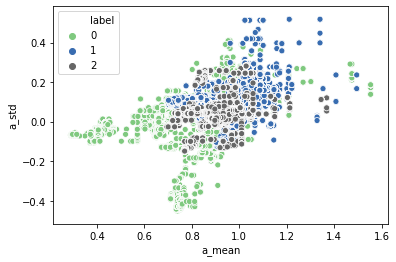

In [9]:
# Now let's visualize the accelerometer mean colored by the affective state label 
sns.scatterplot(x='a_mean',y='a_std',hue='label', data=df_AllData, palette='Accent')

## This scatterplot shows that plotting the accelerometer mean (over all directions), against the accelerometer standard deviation (over all directions) shows a natural separation of the different affective states.

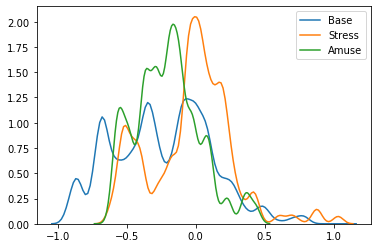

In [10]:
Base_I = df_AllData['label'] == 0
Stress_I = df_AllData['label'] == 1
Amuse_I = df_AllData['label'] == 2

# Let's look at the histogram distributions of the accelerometer peak X frequency
# colored by the target variable
sns.kdeplot(df_AllData.loc[Base_I,'a_maxx'], label="Base")
sns.kdeplot(df_AllData.loc[Stress_I,'a_maxx'], label="Stress")
sns.kdeplot(df_AllData.loc[Amuse_I,'a_maxx'], label="Amuse")
plt.legend();

## These three histograms show that the peak x frequency of the accelerometer show different distributions across the various affective states.  

# Model building training and evaluation

In [11]:
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

import tensorflow as tf

import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding, Flatten
from keras.layers import LSTM
from keras.utils import to_categorical
from keras.optimizers import SGD

# Create feature matrix to feed into the LSTM model
X = df_AllData.drop('label', axis =1).values
y = to_categorical(df_AllData['label'])

# Scale the data between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
X = scaler.fit_transform(X)

# Separate the data into a 75% train / 25% test split.
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.25, random_state=42)


In [12]:
# Reshape the input variables to fit the expected input shape
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [13]:
# There will be 15 neurons in the LSTM network, one for each input.
num_neurons = 15
num_features = 15

print('Building the LSTM network...')

# Create the model instance and define the network structure
model = Sequential()
model.add(LSTM(num_neurons, input_shape=(1, num_features), return_sequences=True))
model.add(LSTM(num_neurons, input_shape=(1, num_features), return_sequences=False))
model.add(Dense(3, activation='sigmoid'))

Building the LSTM network...


In [14]:
# Let's look at a summary of the model
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 1, 15)             1860      
_________________________________________________________________
lstm_2 (LSTM)                (None, 15)                1860      
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 48        
Total params: 3,768
Trainable params: 3,768
Non-trainable params: 0
_________________________________________________________________


In [15]:
# Define the optimizer and compile model
opt = SGD(lr=0.05)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [21]:
print('Training LSTM...')

batch_size = 5 # I think I want to use batch_size = 1

# Now fit the model to the training data
model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=1,
          validation_data=(X_test, y_test))

# Evaluate the fitted moel using the accuracy metric
score, acc = model.evaluate(X_test, y_test, batch_size=batch_size)

Training LSTM...
Train on 91359 samples, validate on 30454 samples
Epoch 1/2
91359/91359 [==============================] - 30s 334us/step - loss: 0.2204 - accuracy: 0.9019 - val_loss: 0.1814 - val_accuracy: 0.9230
Epoch 2/2
30454/30454 [==============================] - 2s 75us/step


In [20]:
print('score:', score)
print('accuracy:', acc)

score: 0.2576251168479635
accuracy: 0.8820521831512451


## Here we see that with two epochs my model achieves 92% accuracy.  

In [24]:
def get_new_model():

    # Create the model instance and define the network structure
    model = Sequential()
    model.add(LSTM(num_neurons, input_shape=(1, num_features), return_sequences=True))
    model.add(LSTM(num_neurons, input_shape=(1, num_features), return_sequences=False))
    model.add(Dense(3, activation='sigmoid'))
    
    return model

In [ ]:
# Import EarlyStopping
from keras.callbacks import EarlyStopping

# Learning rates to iterate over
lr_to_test = np.arange(0.01,0.1,0.01)

# Define early_stopping_monitor
early_stopping_monitor = EarlyStopping(patience=2)

# Initialize the variables recording score, accuracy and Stop_epoch
score = np.zeros(len(lr_to_test))
acc = np.zeros(len(lr_to_test))
Stop_epoch = np.zeros(len(lr_to_test))

print('Training LSTM...')

batch_size = 5 # I think I want to use batch_size = 1

# Loop over learning rates
for i, lr in enumerate(lr_to_test):
    print('\n\nTesting model with learning rate: %f\n'%lr )
    
    # Build new model to test, unaffected by previous models
    model = get_new_model()
    
    # Create SGD optimizer with specified learning rate: my_optimizer
    my_optimizer = SGD(lr=lr)
    
    # Compile the model
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    # Now fit the model to the training data
    model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=20,
          validation_data=(X_test, y_test),
          callbacks=[early_stopping_monitor])
    
    # For each learning rate, evaluate the fitted model using the accuracy metric
    score[i], acc[i] = model.evaluate(X_test, y_test, batch_size=batch_size)
    
    # For each learning rate, record the epoch where training was stopped
    Stop_epoch[i] = early_stopping_monitor.stopped_epoch

Training LSTM...


Testing model with learning rate: 0.010000

Train on 91359 samples, validate on 30454 samples
Epoch 1/20
91359/91359 [==============================] - 31s 339us/step - loss: 0.5576 - accuracy: 0.7175 - val_loss: 0.4910 - val_accuracy: 0.7823
Epoch 2/20
91359/91359 [==============================] - 29s 323us/step - loss: 0.4572 - accuracy: 0.7984 - val_loss: 0.3986 - val_accuracy: 0.8370
Epoch 3/20
91359/91359 [==============================] - 29s 323us/step - loss: 0.3527 - accuracy: 0.8472 - val_loss: 0.2966 - val_accuracy: 0.8690
Epoch 4/20
91359/91359 [==============================] - 31s 340us/step - loss: 0.2606 - accuracy: 0.8875 - val_loss: 0.2047 - val_accuracy: 0.9091
Epoch 5/20
91359/91359 [==============================] - 29s 321us/step - loss: 0.1907 - accuracy: 0.9180 - val_loss: 0.1792 - val_accuracy: 0.9228
Epoch 6/20
91359/91359 [==============================] - 30s 331us/step - loss: 0.1429 - accuracy: 0.9389 - val_loss: 0.1190 - val_accuracy: 

In [18]:

# sns.pairplot(df_AllData,
#              kind="scatter", 
#              hue='label')